In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.patches as mpatches
from sklearn import linear_model, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from random import randint, choice, choices

In [256]:
df = pd.read_csv('heart.csv')

https://www.kaggle.com/fedesoriano/heart-failure-prediction

<h1>First Look to Our Data</h1>

<ol>
<li>Age: age of the patient [years]</li>
<li>Sex: sex of the patient [M: Male, F: Female]</li>
<li>ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]</li>
<li>RestingBP: resting blood pressure [mm Hg]</li>
<li>Cholesterol: serum cholesterol [mm/dl]</li>
<li>FastingBS: fasting blood sugar [1: if FastingBS &gt; 120 mg/dl, 0: otherwise]</li>
<li>RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of &gt; 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]</li>
<li>MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]</li>
<li>ExerciseAngina: exercise-induced angina [Y: Yes, N: No]</li>
<li>Oldpeak: oldpeak = ST [Numeric value measured in depression]</li>
<li>ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]</li>
<li>HeartDisease: output class [1: heart disease, 0: Normal]</li>
</ol>

In [257]:
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [258]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [259]:
df.duplicated().sum()

0

In [260]:
df.shape

(918, 12)

<h1>Exploratary Data Analysis & Visualization</h1>

In [261]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = df.select_dtypes(include=numerics)

In [262]:
newdf.groupby('HeartDisease').mean()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
HeartDisease,,,,,,
0,50.551220,130.180488,227.121951,0.107317,148.151220,0.408049
1,55.899606,134.185039,175.940945,0.334646,127.655512,1.274213


<b>We can clearly see the difference in heart values between patients who has heart disease and who has not</b>

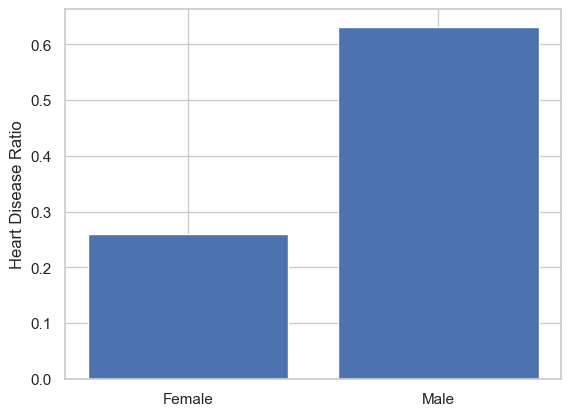

In [263]:
plt.bar(['Female', 'Male'] ,df.groupby('Sex')['HeartDisease'].mean().array)
plt.ylabel('Heart Disease Ratio')
plt.show()

<b>Males have approximately 2.5 times more chance to have a heart disease than females according to this data</b>

------------------------------
Variable:  {'Age'}


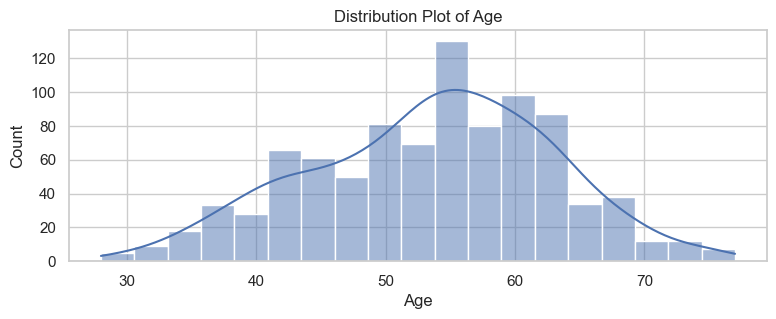

------------------------------
Variable:  {'RestingBP'}


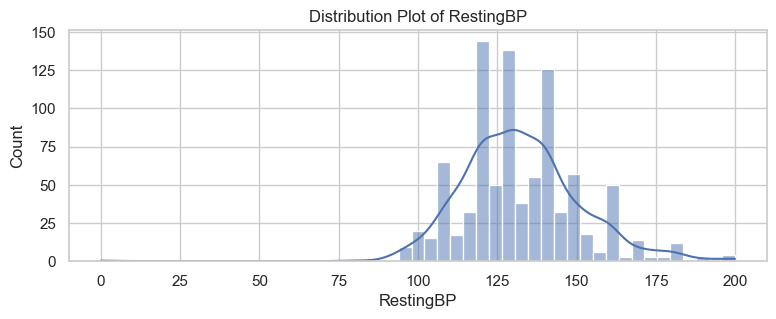

------------------------------
Variable:  {'Cholesterol'}


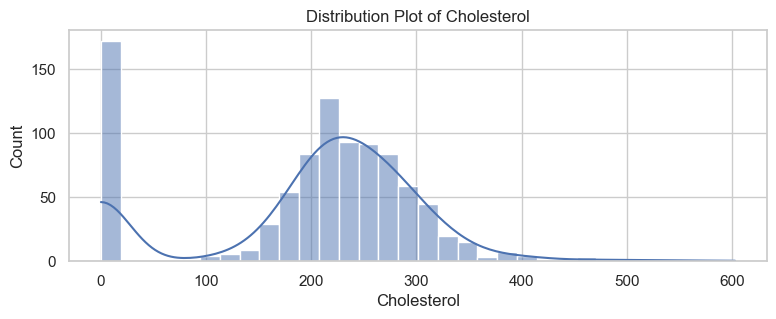

------------------------------
Variable:  {'FastingBS'}


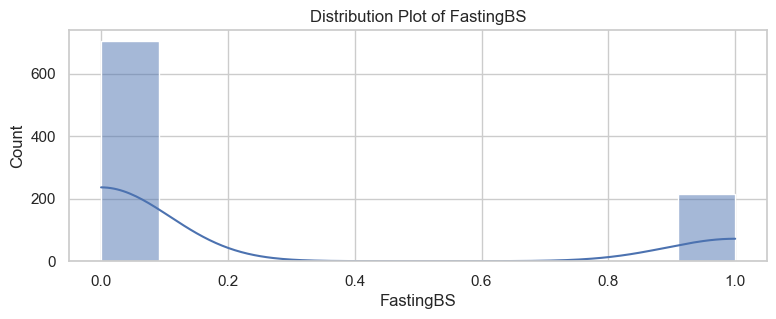

------------------------------
Variable:  {'MaxHR'}


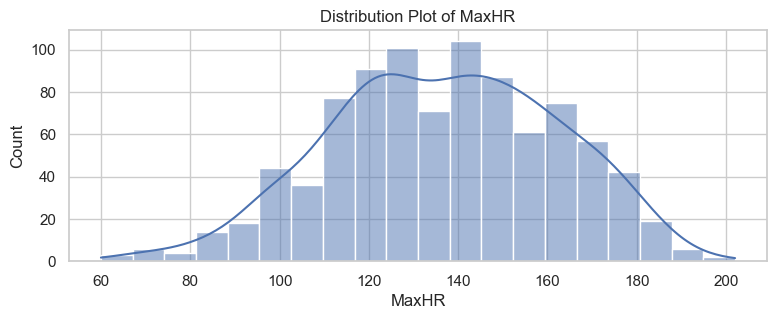

------------------------------
Variable:  {'Oldpeak'}


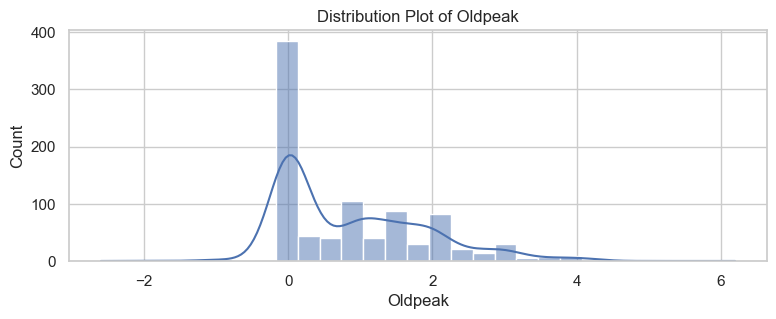

------------------------------
Variable:  {'HeartDisease'}


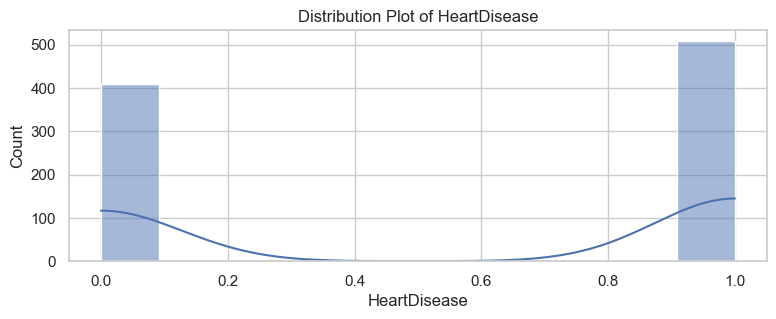

In [264]:
cols_num = df.select_dtypes(include = ['float','int']).columns.to_list()
for col in cols_num:
    sns.set(style='whitegrid')
    plt.figure(figsize=(9, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution Plot of {col}')
    print('--' * 15)
    print("Variable: ", {col})
    plt.show()

<h1>Data Preprocessing</h1>

<h3>Data cleaning</h3>

In [265]:
int_columns = newdf.drop(['FastingBS', 'HeartDisease'], axis=1).columns

In [266]:
for col in int_columns:
    minusz = df[col].mean() - 3 * df[col].std()
    plusz = df[col].mean() + 3 * df[col].std()
    df = df[(df[col] > minusz) & (df[col] < plusz)]
df.reset_index(drop=True, inplace=True)

In [268]:
cols_str = df.select_dtypes(exclude=['float','int']).columns.to_list()
for col in cols_str:
    one_hot = LabelEncoder()
    df[col] = one_hot.fit_transform(df[col])

In [269]:
X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']

In [270]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

<h1>Models</h1>

In [271]:
def modeling(model, params):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=50)
    grid = GridSearchCV(
                        model,  
                        params, 
                        cv=cv, 
                        return_train_score=False,
                        )
    grid.fit(X, Y)
    print(f"For Model {model}: \nBest Params -> {grid.best_params_} \nBest Score -> {grid.best_score_}")

In [272]:
modeling(SVC(), {'kernel': ['linear', 'rbf'], 'C': range(1,5)})

For Model SVC(): 
Best Params -> {'C': 3, 'kernel': 'rbf'} 
Best Score -> 0.8665238981998759


In [273]:
modeling(RandomForestClassifier(), {'criterion': ['gini', 'entropy']})

For Model RandomForestClassifier(): 
Best Params -> {'criterion': 'gini'} 
Best Score -> 0.8665301055245189


In [274]:
modeling(LogisticRegression(), {'max_iter': [50, 100, 200], 'C': range(1,5)})

For Model LogisticRegression(): 
Best Params -> {'C': 4, 'max_iter': 50} 
Best Score -> 0.8475977653631286


In [275]:
modeling(DecisionTreeClassifier(), {'criterion': ['gini', 'entropy']})

For Model DecisionTreeClassifier(): 
Best Params -> {'criterion': 'entropy'} 
Best Score -> 0.7986902545003105


In [276]:
modeling(KNeighborsClassifier(), {'n_neighbors': range(1,10)})

For Model KNeighborsClassifier(): 
Best Params -> {'n_neighbors': 5} 
Best Score -> 0.8564990689013037


In [277]:
modeling(MultinomialNB(), {'fit_prior': [True, False]})

For Model MultinomialNB(): 
Best Params -> {'fit_prior': True} 
Best Score -> 0.8108317815021726


<b>We can see that best model is random forest classifier</b>